## 1. Get data

In [1]:
# import os
# import requests
# import zipfile
# from pathlib import Path

# # Setup path to data folder
# data_path = Path("../data")
# image_path = data_path / "pizza_steak_sushi"

# # If the image folder doesn't exist, download it and prepare it... 
# if image_path.is_dir():
#     print(f"{image_path} directory exists.")
# else:
#     print(f"Did not find {image_path} directory, creating one...")
#     image_path.mkdir(parents=True, exist_ok=True)

# # Download pizza, steak, sushi data
# with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
#     request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
#     print("Downloading pizza, steak, sushi data...")
#     f.write(request.content)

# # Unzip pizza, steak, sushi data
# with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
#     print("Unzipping pizza, steak, sushi data...") 
#     zip_ref.extractall(image_path)<

# # Remove zip file
# os.remove(data_path / "pizza_steak_sushi.zip")


## 2. Create Datasets and DataLoaders 

In [27]:
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

Feature batch shape: torch.Size([32, 3, 64, 64])
Labels batch shape: torch.Size([32])


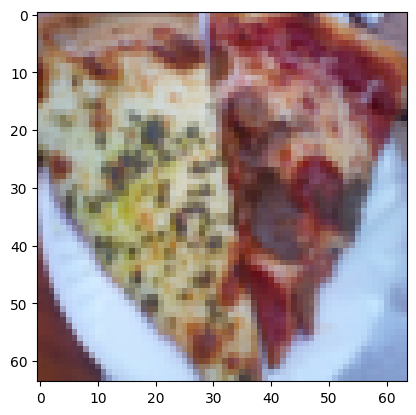

Label: 0


In [73]:
import matplotlib.pyplot as plt
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 3. Making a model

In [35]:
import torch
from torch import nn 

class Bottleneck(nn.Module):
    def __init__(self, in_channels, intermediate_channels, expansion, is_bottleneck, stride):
        super(Bottleneck, self).__init__()
        
        self.in_channels = in_channels
        self.intermediate_channels = intermediate_channels
        self.expansion = expansion
        self.is_bottleneck = is_bottleneck
        self.stride = stride
        
        self.out_channels = self.intermediate_channels * self.expansion
        self.relu = nn.ReLU()
        
        # Determine if identity function should be used
        self.identity = self.in_channels == self.out_channels
        
        # Projection layer if needed
        if not self.identity:
            self.projection = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(self.out_channels)
            )
        
        # Define layers based on bottleneck or basic block
        if self.is_bottleneck:
            self.conv1_1x1 = self._conv_bn_relu(in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0)
            self.conv2_3x3 = self._conv_bn_relu(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1)
            self.conv3_1x1 = nn.Conv2d(in_channels=intermediate_channels, out_channels=self.out_channels, kernel_size=1, stride=1, padding=0, bias=False)
            self.batchnorm3 = nn.BatchNorm2d(self.out_channels)
        else:
            self.conv1_3x3 = self._conv_bn_relu(in_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1)
            self.conv2_3x3 = self._conv_bn(in_channels, intermediate_channels, kernel_size=3, stride=1, padding=1)
        
    def _conv_bn_relu(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    
    def _conv_bn(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        # Store input to be added before the final ReLU
        in_x = x
        
        if self.is_bottleneck:
            x = self.conv1_1x1(x)
            x = self.conv2_3x3(x)
            x = self.relu(self.batchnorm3(self.conv3_1x1(x)))
        else:
            x = self.conv1_3x3(x)
            x = self.conv2_3x3(x)
        
        # Apply identity or projected mapping
        if self.identity:
            x = x + in_x
        else:
            x = x + self.projection(in_x)
        
        # Final ReLU
        x = self.relu(x)
        
        return x

In [36]:
class ResNet(nn.Module):

    def __init__(self, resnet_variant,in_channels,num_classes):
        """
        Creates the ResNet architecture based on the provided variant. 18/34/50/101 etc.
        Based on the input parameters, define the channels list, repeatition list along with expansion factor(4) and stride(3/1)
        using _make_blocks method, create a sequence of multiple Bottlenecks
        Average Pool at the end before the FC layer 

        Args:
            resnet_variant (list) : eg. [[64,128,256,512],[3,4,6,3],4,True]
            in_channels (int) : image channels (3)
            num_classes (int) : output #classes 

        Attributes:
            Layer consisting of conv->batchnorm->relu

        """
        # ([64, 128, 256, 512], [3, 4, 6, 3], 4, True
        super(ResNet,self).__init__()
        self.channels_list = resnet_variant[0]
        self.repeatition_list = resnet_variant[1]
        self.expansion = resnet_variant[2]
        self.is_Bottleneck = resnet_variant[3]

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False )
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.block1 = self._make_blocks( 64 , self.channels_list[0], self.repeatition_list[0], self.expansion, self.is_Bottleneck, stride=1 )
        self.block2 = self._make_blocks( self.channels_list[0]*self.expansion , self.channels_list[1], self.repeatition_list[1], self.expansion, self.is_Bottleneck, stride=2 )
        self.block3 = self._make_blocks( self.channels_list[1]*self.expansion , self.channels_list[2], self.repeatition_list[2], self.expansion, self.is_Bottleneck, stride=2 )
        self.block4 = self._make_blocks( self.channels_list[2]*self.expansion , self.channels_list[3], self.repeatition_list[3], self.expansion, self.is_Bottleneck, stride=2 )

        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear( self.channels_list[3]*self.expansion , num_classes)



    def forward(self,x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.block1(x)
        
        x = self.block2(x)
        
        x = self.block3(x)
        
        x = self.block4(x)
        
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        
        return x

    def _make_blocks(self,in_channels,intermediate_channels,num_repeat, expansion, is_Bottleneck, stride):
        
        """
        Args:
            in_channels : #channels of the Bottleneck input
            intermediate_channels : #channels of the 3x3 in the Bottleneck
            num_repeat : #Bottlenecks in the block
            expansion : factor by which intermediate_channels are multiplied to create the output channels
            is_Bottleneck : status if Bottleneck in required
            stride : stride to be used in the first Bottleneck conv 3x3

        Attributes:
            Sequence of Bottleneck layers

        """
        layers = [] 

        layers.append(Bottleneck(in_channels,intermediate_channels,expansion,is_Bottleneck,stride=stride))
        for num in range(1,num_repeat):
            layers.append(Bottleneck(intermediate_channels*expansion,intermediate_channels,expansion,is_Bottleneck,stride=1))

        return nn.Sequential(*layers)


## 4. Creating train_step() and test_step() functions and train() to combine them

In [37]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and y_pred_classaccumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results


## 5. Creating a function to save the model (utils.py)

In [38]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

## 6. Train, evaluate and save the model (train.py)

In [40]:
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch

from torchvision import transforms
torch.autograd.set_detect_anomaly(True)

# Setup hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup directories
train_dir = "../data/pizza_steak_sushi/train"
test_dir = "../data/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
# resnetX = (Num of channels, repetition, Bottleneck_expansion , Bottleneck_layer)
model_parameters={}
model_parameters['resnet18'] = ([64,128,256,512],[2,2,2,2],1,False)
model_parameters['resnet34'] = ([64,128,256,512],[3,4,6,3],1,False)
model_parameters['resnet50'] = ([64,128,256,512],[3,4,6,3],4,True)
model_parameters['resnet101'] = ([64,128,256,512],[3,4,23,3],4,True)
model_parameters['resnet152'] = ([64,128,256,512],[3,8,36,3],4,True)
architecture = 'resnet50'
params = model_parameters[architecture]
model = ResNet(params , in_channels=3, num_classes=3).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      epochs=NUM_EPOCHS,
      device=device)

# Save the model with help from utils.py
save_model(model=model,
          target_dir="../models",
          model_name=".05_going_modular_script_mode_tinyvgg_model.pth")

  5%|▌         | 1/20 [00:07<02:29,  7.85s/it]

Epoch: 1 | train_loss: 2.1905 | train_acc: 0.4570 | test_loss: 1.1502 | test_acc: 0.5417


 10%|█         | 2/20 [00:15<02:20,  7.79s/it]

Epoch: 2 | train_loss: 2.0817 | train_acc: 0.4258 | test_loss: 1.5769 | test_acc: 0.2604


 15%|█▌        | 3/20 [00:23<02:10,  7.69s/it]

Epoch: 3 | train_loss: 1.9843 | train_acc: 0.4961 | test_loss: 2.3512 | test_acc: 0.2708


 20%|██        | 4/20 [00:30<02:02,  7.66s/it]

Epoch: 4 | train_loss: 1.6849 | train_acc: 0.4062 | test_loss: 1.2846 | test_acc: 0.3930


 25%|██▌       | 5/20 [00:38<01:55,  7.68s/it]

Epoch: 5 | train_loss: 3.0079 | train_acc: 0.5430 | test_loss: 1.4351 | test_acc: 0.4943


 30%|███       | 6/20 [00:46<01:47,  7.64s/it]

Epoch: 6 | train_loss: 1.4327 | train_acc: 0.5898 | test_loss: 2.4788 | test_acc: 0.2917


 35%|███▌      | 7/20 [00:53<01:39,  7.67s/it]

Epoch: 7 | train_loss: 1.7261 | train_acc: 0.5977 | test_loss: 3.2963 | test_acc: 0.4545


 40%|████      | 8/20 [01:01<01:31,  7.66s/it]

Epoch: 8 | train_loss: 1.1500 | train_acc: 0.6602 | test_loss: 6.7202 | test_acc: 0.4233


 45%|████▌     | 9/20 [01:09<01:24,  7.65s/it]

Epoch: 9 | train_loss: 1.0599 | train_acc: 0.7852 | test_loss: 3.5118 | test_acc: 0.3939


 50%|█████     | 10/20 [01:16<01:16,  7.64s/it]

Epoch: 10 | train_loss: 0.9135 | train_acc: 0.7148 | test_loss: 16.6846 | test_acc: 0.4044


 55%|█████▌    | 11/20 [01:24<01:08,  7.64s/it]

Epoch: 11 | train_loss: 0.6664 | train_acc: 0.8594 | test_loss: 10.2652 | test_acc: 0.3220


 60%|██████    | 12/20 [01:31<01:00,  7.61s/it]

Epoch: 12 | train_loss: 0.4454 | train_acc: 0.7891 | test_loss: 3.5875 | test_acc: 0.3002


 65%|██████▌   | 13/20 [01:39<00:53,  7.59s/it]

Epoch: 13 | train_loss: 1.0443 | train_acc: 0.7227 | test_loss: 1.6299 | test_acc: 0.4650


 70%|███████   | 14/20 [01:47<00:45,  7.59s/it]

Epoch: 14 | train_loss: 0.8807 | train_acc: 0.8477 | test_loss: 1.8096 | test_acc: 0.4744


 75%|███████▌  | 15/20 [01:54<00:37,  7.60s/it]

Epoch: 15 | train_loss: 0.8435 | train_acc: 0.7695 | test_loss: 1.5331 | test_acc: 0.5133


 80%|████████  | 16/20 [02:02<00:30,  7.57s/it]

Epoch: 16 | train_loss: 0.4680 | train_acc: 0.9219 | test_loss: 1.5588 | test_acc: 0.4953


 85%|████████▌ | 17/20 [02:09<00:22,  7.56s/it]

Epoch: 17 | train_loss: 1.9786 | train_acc: 0.8086 | test_loss: 1.7073 | test_acc: 0.5057


 90%|█████████ | 18/20 [02:17<00:15,  7.54s/it]

Epoch: 18 | train_loss: 0.1763 | train_acc: 0.9688 | test_loss: 2.1028 | test_acc: 0.5237


 95%|█████████▌| 19/20 [02:24<00:07,  7.53s/it]

Epoch: 19 | train_loss: 0.5252 | train_acc: 0.8438 | test_loss: 3.2100 | test_acc: 0.4328


100%|██████████| 20/20 [02:32<00:00,  7.61s/it]

Epoch: 20 | train_loss: 1.0569 | train_acc: 0.7148 | test_loss: 5.2428 | test_acc: 0.3693
[INFO] Saving model to: ../models/.05_going_modular_script_mode_tinyvgg_model.pth


In [80]:
# Import model
model = ResNet(params , in_channels=3, num_classes=3).to(device)
model.load_state_dict(torch.load("../models/.05_going_modular_script_mode_tinyvgg_model.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Bottleneck(
      (relu): ReLU()
      (projection): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1_1x1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2_3x3): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

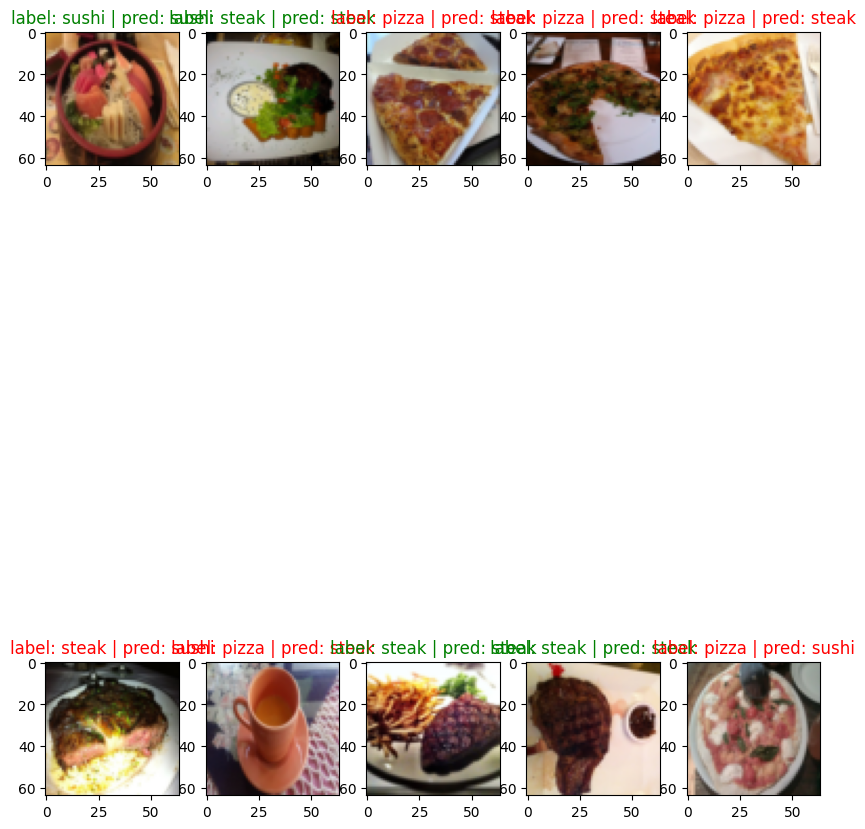

In [126]:
import random
import matplotlib.pyplot as plt

# Get a batch of training features and labels
train_features, train_labels = next(iter(train_dataloader))

# Define the number of images to display
nb_images = 10

# Choose random images from the batch
random_images = True
batch_size = train_features.size()[0]
ids = random.sample(range(0, batch_size), nb_images) if random_images else range(0, nb_images)
images = train_features[ids]
labels = train_labels[ids]

# Plot the images along with their labels and predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 10))
for ax, image, label in zip(axes.flatten(), images, labels):
    # Make prediction using the model
    pred = model(image.unsqueeze(0)).argmax().item()

    # Define the title color based on label and pred equality
    title_color = 'green' if label == pred else 'red'

    # Display the image with the title color
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"label: {class_names[label]} | pred: {class_names[pred]}", color=title_color)


plt.show()
